### Colorization

**Let there be Color!: Joint End-to-end Learning of Global and Local Image Priors for Automatic Image Colorization with Simultaneous Classification**
Satoshi Iizuka\*, Edgar Simo-Serra\*, Hiroshi Ishikawa (* equal contribution)
ACM Transactions on Graphics (SIGGRAPH) , 2016

#### About colorization

* [Website](http://iizuka.cs.tsukuba.ac.jp/projects/colorization/)
* [Paper](https://esslab.jp/publications/IizukaSIGGRAPH2016.pdf)

#### Objectives

1. Test baseline
1. Finish implementing global and local network
1. Explain why the global feature network helps (hint: spatial resolution)
1. Add classification loss (hint: it is possible to modify forward() to return multiple values. Set the classification loss to 1/300 of the reconstruction loss)

PUT ANSWER TO WHY GLOBAL FEATURES HELP HERE

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

<img src='deepcolor.png' alt='Colorization network' style='max-width:800px;'/>

####  Regarding the model

* Conv: convolutional layer
* FC: fully connected layer
* Fusion: fusion layer
* Upsample: upscaling layer
* Apply TanH to ouptut

#### Improvements

1. Reduced filters from 512 to 256
1. Last layer restores to original resolution

In [2]:
class ConvLayer(nn.Module):
    def __init__(self, fan_in, fan_out, kernel=3, stride=1, padding=1, upscale=None):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d( fan_in, fan_out, kernel_size=kernel, stride=stride, padding=padding, bias=False )
        self.bn   = nn.BatchNorm2d( fan_out )
        self.upscale = upscale
    def forward(self, x):
        if self.upscale != None:
            x = F.interpolate( x, scale_factor=self.upscale, mode='bilinear', align_corners=False)
        return F.relu( self.bn( self.conv(x) ) )
    
class FCLayer(nn.Module):
    def __init__(self, fan_in, fan_out ):
        super(ConvLayer, self).__init__()
        self.fc = nn.Linear( fan_in, fan_out )
        self.bn = nn.BatchNorm( fan_out )
    def forward(self, x):
        return F.relu( self.bn( self.fc(x) ) )

class FusionLayer(nn.Module):
    def __init__(self, fan_in, fan_out, inner_size ):
        super(FusionLayer, self).__init__()
        self.conv = ConvLayer( fan_in, fan_out, kernel=1, padding=0 )
        self.inner_size = inner_size
    def forward(self, l, g):
        x = torch.cat( [l, g.repeat(1,1,self.inner_size,self.inner_size)], dim=1 )
        return self.conv(x)

#### モデルのクラス

In [3]:
class Net(nn.Module):
    def __init__(self, use_global=True, use_tanh=True):
        super(Net, self).__init__()
        self.use_global = use_global
        self.use_tanh = use_tanh
        
        self.lowlevel = nn.Sequential(
            ConvLayer(   1,  64, stride=2 ), # 64
            ConvLayer(  64, 128 ),
            ConvLayer( 128, 128, stride=2 ), # 32
            ConvLayer( 128, 256 ),
            ConvLayer( 256, 256, stride=2 ), # 16
            ConvLayer( 256, 256 )
        )
        
        self.midlevel = nn.Sequential(
            ConvLayer( 256, 256 ),
            ConvLayer( 256, 256 )
        )
        
        if self.use_global:
            self.globalfeat = nn.Sequential(
                ConvLayer( 256, 256, stride=2 ), # 8
                ConvLayer( 256, 256 ),
                ConvLayer( 256, 256, stride=2 ), # 4
                ConvLayer( 256, 256 ),
                ConvLayer( 256, 512, kernel=4, padding=0 ), # 1
                ConvLayer( 512, 256, kernel=1, padding=0 )
            )

            self.fusion = FusionLayer( 512, 256, 16 )

            self.classifier = nn.Sequential(
                ConvLayer( 256, 128, kernel=1, padding=0 ),
                nn.Conv2d( 128,   6, kernel_size=1, padding=0 )
            )

        self.colorization = nn.Sequential(
            ConvLayer( 256, 128 ),
            ConvLayer( 128,  64, upscale=2. ),
            ConvLayer(  64,  64 ),
            ConvLayer(  64,  32, upscale=2. ),
            ConvLayer(  32,  16, upscale=2. ),
            nn.Conv2d(  16,   2, kernel_size=3, padding=1 )
        )
        
    def forward( self, x ):
        l = self.lowlevel( x )
        m = self.midlevel( l )
        c = self.colorization( m )
        if self.use_tanh:
            c = torch.tanh( c )
        return torch.cat( [x, c], dim=1 )
        

#### Prepare data

Download from [here](https://esslab.jp/~ess/files/tinyplaces.tar.gz) and unzip into `../data`.

1. 6 classes from places (bamboo_forest, coast, corn_field, sea_cliff, tree_farm, volcano)
1. class labels available
1. Converted to CIE Lab colorspace

In [4]:
import torchvision
from skimage import color
import numpy as np
from PIL import Image
import random
def lab_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        rgb = img.convert('RGB')
        lab = color.rgb2lab(rgb)
        return lab.astype(np.float32)
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((50,0,0,), (50,128,128,))
])
data = torchvision.datasets.ImageFolder('../data/tinyplaces/', transform=transform, loader=lab_loader)

idx       = list(range(len(data)))
random.shuffle(idx)
idx       = idx[0:10000]
limit     = int(0.1*len(idx))
test_idx  = idx[:limit]
train_idx = idx[limit:]
train_sampler = torch.utils.data.sampler.SubsetRandomSampler( train_idx )
train_loader = torch.utils.data.DataLoader( data, batch_size=16, sampler=train_sampler )

#### Create model and optimization approach

In [5]:
device = torch.device("cuda" if (torch.cuda.device_count()>0) else "cpu")
model = Net().to(device)
optimizer = torch.optim.Adadelta( model.parameters() )

#### Training loop

In [6]:
loss_log = []

In [12]:
from tqdm import tqdm
model.train()
t = tqdm(train_loader)
for x,y in t:
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    L  = x[:,0:1,:,:].detach()
    ab = x[:,1:3,:,:].detach()
    
    pred = model(L)
    loss = torch.pow( pred-x, 2 ).mean()
    t.set_postfix( loss=loss.item() )
    loss_log.append( loss.item() )
    loss.backward()
    optimizer.step()

100%|██████████| 563/563 [00:31<00:00, 17.93it/s, loss=0.00299]


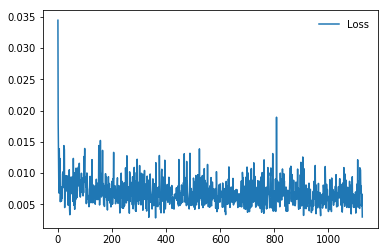

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot( loss_log, label='Loss' )
plt.legend( frameon=False )

#### Results

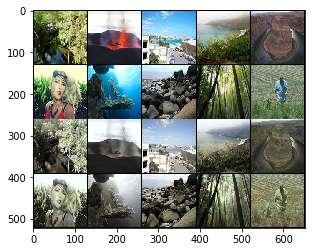

In [14]:
import torchvision
import matplotlib.pyplot as plt

def tolab( x ):
    x = x[0].clone()
    x[0,:,:]  = 50 + 50*x[0,:,:]
    x[1,:,:] *= 128
    x[2,:,:] *= 128
    return torch.Tensor( color.lab2rgb( x.permute(1,2,0) )).permute(2,0,1).unsqueeze(0)

model.eval()
N = 10
I = torch.zeros( N*2, 3, 128, 128 )
with torch.no_grad():
    for i,idx in enumerate(test_idx[:N]):
        x  = data[idx][0].unsqueeze(0)
        L  = x[:,0:1,:,:]
        ab = x[:,1:3,:,:]

        pred = model(L.to(device)).cpu()
        I[i,:,:,:]   = tolab( x )
        I[N+i,:,:,:] = tolab( pred )

I = torchvision.utils.make_grid( I, nrow=5 )
plt.imshow( I.permute(1, 2, 0) )

#### Spatial resolution

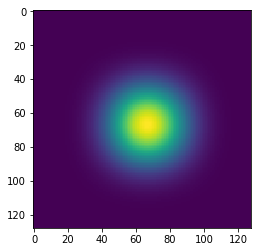

In [10]:
I = torch.zeros(1,1,128,128)
I[0,0,63,63] = 1
m = Net( use_global=True, use_tanh=False )
for name, p in m.named_parameters():
    if 'weight' in name:
        nn.init.constant_(p,1)
    elif 'bias' in name:
        nn.init.constant_(p,0)
m.double()
m.eval()
with torch.no_grad():
    I = m( I.double() )
plt.imshow(I[0,1,:,:] / I[0,1,:,:].max() )

#### Display model

https://github.com/waleedka/hiddenlayer

###### Install

````
conda install graphviz python-graphviz
pip install hiddenlayer
````

In [21]:
import hiddenlayer as hl
hl.build_graph( model.cpu(), torch.zeros([1, 1, 128, 128]) )

RuntimeError: Failed to export an ONNX attribute, since it's not constant, please try to make things (e.g., kernel size) static if possible